<h1 style="text-align:center">
    Principal Component Analysis with the Palmer Archipielago Penguins Dataset
</h1>
<div style="text-align: center;">
<img src="https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png" width="600"/>
</div>

The Palmer Archipelago penguins dataset is a rich resource for understanding the physical characteristics of three species of penguins: Adelie, Chinstrap, and Gentoo. This dataset includes measurements such as culmen length, culmen depth, flipper length, body mass, and the sex of the penguins. By applying Principal Component Analysis (PCA) to this dataset, I aim to distill the complexity of these measurements into a few principal components that capture the most significant patterns in the data.

Principal Component Analysis (PCA) is a powerful statistical technique used to reduce the dimensionality of data while preserving as much variability as possible. This is achieved by transforming the original variables into a new set of uncorrelated variables called principal components. Each principal component is a linear combination of the original variables, and they are ordered such that the first few retain most of the variation present in the original variables.

The application of PCA to the Palmer Archipelago penguins dataset has several objectives:

* Determine the most correlated pairs of physical characteristics among the penguins.
* Assess the number of components required to effectively capture the variability in the dataset.
* Perform PCA on the correlation matrix and decide the number of principal components to retain based on the previously determined optimal number.
* Explain what each principal component represents in terms of the physical characteristics of the penguins.
* Analyze the positioning of penguin species in the PCA graph to identify which species stand out in each principal component.
* Evaluate the contributions of the principal components to the explained variability of the original variables and the contributions of the original variables to the principal components.
* Examine any inherent clustering within the data based on the principal components.
* Use both hierarchical and non-hierarchical analysis methods to determine the optimal number of clusters in the dataset.
* Evaluate the quality and coherence of the identified clusters.
* Summarize the findings from the PCA and clustering analyses, highlighting key insights about the physical characteristics and species differentiation of the Palmer Archipelago penguins.

# Importing Libraries and Loading the Dataset

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import seaborn as sns
from lib import *
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None

In [3]:
penguins = pd.read_csv('data/penguins_size.csv')

# Quick Analysis on the Penguins Dataset

In [4]:
penguins.shape

(344, 7)

In [5]:
penguins.columns

Index(['species', 'island', 'culmen_length_mm', 'culmen_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex'],
      dtype='object')

In [6]:
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [7]:
penguins.dtypes

species               object
island                object
culmen_length_mm     float64
culmen_depth_mm      float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

I see that there are 3 categorical variables. PCA analysis requires continuous variables, so the next step will be to keep only the numerical ones and save the categorical ones.

In [8]:
var_cont = list(penguins.select_dtypes(include=['int', 'int32', 'int64','float', 'float32', 'float64']).columns)
var_categ = [variable for variable in penguins if variable not in var_cont]

In [9]:
save = penguins[var_categ]
penguins = penguins[var_cont]

In [10]:
penguins.isna().sum()

culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
dtype: int64

In [11]:
# 2 of the rows are NaNs. We proceed to delete them
penguins.dropna(inplace=True)

In [12]:
penguins

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
338,47.2,13.7,214.0,4925.0
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


In [13]:
variables = list(penguins.columns)   

In [14]:
stats = pd.DataFrame({
    'Min': penguins[variables].min(),
    'Percentile 25': penguins[variables].quantile(0.25),
    'Median': penguins[variables].median(),
    'Percentile 75': penguins[variables].quantile(0.75),
    'Mean': penguins[variables].mean(),
    'Max': penguins[variables].max(),
    'STD': penguins[variables].std(),
    'VAR': penguins[variables].var(),
    'Missing Values': penguins[variables].isna().sum()  # Cuenta los valores NaN por variable.
})
stats.round(2)

,Min,Percentile 25,Median,Percentile 75,Mean,Max,STD,VAR,Missing Values
culmen_length_mm,32.1,39.22,44.45,48.5,43.92,59.6,5.46,29.81,0
culmen_depth_mm,13.1,15.60,17.30,18.7,17.15,21.5,1.97,3.90,0
flipper_length_mm,172.0,190.00,197.00,213.0,200.92,231.0,14.06,197.73,0
body_mass_g,2700.0,3550.00,4050.00,4750.0,4201.75,6300.0,801.95,643131.08,0


A priori I can see that the data is within the reasonable limits of dimensions and weights of penguins, so the dataset is ready to start working.

# What are the most correlated variables between the physical characteristics of the penguins?

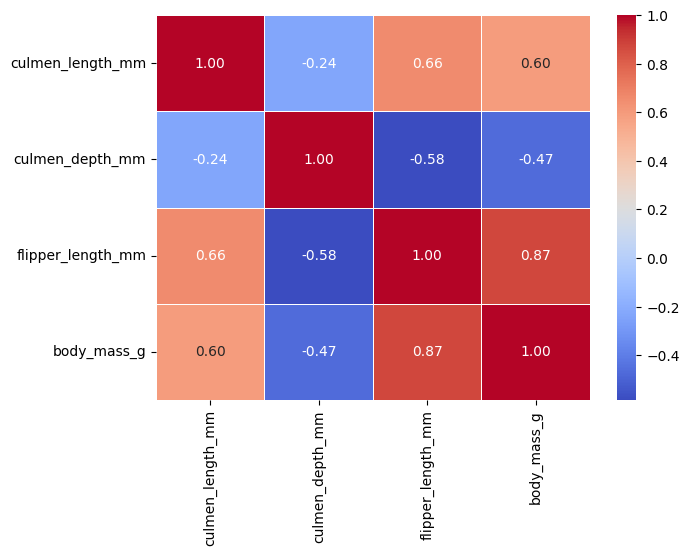

In [15]:
# Calculate the covariance matrix
C = penguins.cov()
# Calculate and represent the correlation matrix between the variables of the DataFrame 'penguins'.
R = penguins.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(R, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

The most correlated variables are: *body_mass_g* with *flipper_length_mm*, slightly followed by *bill_length_mm* with *flipper_length_mm*

# What is the appropriate number of components to efficiently represent the variability of penguin species?
Perform a principal components analysis (PCA) on the correlation matrix, calculating an appropriate number of components (maximum 4). Study the values ​​of the eigenvalues ​​obtained and the graphs that summarize them.

In [16]:
# First we create a standardized_penguins dataframe using StandardScaler() for the penguins data
standard_penguins = pd.DataFrame(
    StandardScaler().fit_transform(penguins),  # Datos estandarizados
    columns=['{}_z'.format(variable) for variable in variables],  # Nombres de columnas estandarizadas
    index=penguins.index  # Índices (etiquetas de filas) del DataFrame
)

In [17]:
# I define the PCA of 4 components so that I can see all the available components
pca = PCA(n_components=4)
fit = pca.fit(standard_penguins)

In [18]:
eigenvalues = fit.explained_variance_
eigenvectors = pd.DataFrame(pca.components_.T, 
                            columns = ['Eigenvector {}'.format(i) for i in range(1, fit.n_components_+1)],
                            index = ['{}_z'.format(variable) for variable in variables])
pca_results = pd.DataFrame(fit.transform(standard_penguins), 
                              columns=['Component {}'.format(i) for i in range(1, fit.n_components_+1)],
                              index=standard_penguins.index)
explained_var = fit.explained_variance_ratio_*100
explained_var

array([68.8438781 , 19.31291885,  9.13089766,  2.7123054 ])

In [19]:
accumulated_var = np.cumsum(explained_var)

In [20]:
data = {'eigenvalues': eigenvalues, 'Explained Variability': explained_var, 'Cumulative Variability': accumulated_var}
table = pd.DataFrame(data, index=['Component {}'.format(i) for i in range(1, fit.n_components_+1)]) 

# Imprimir la tabla
print(table)

             eigenvalues  Explained Variability  Cumulative Variability
Component 1     2.761831              68.843878               68.843878
Component 2     0.774782              19.312919               88.156797
Component 3     0.366307               9.130898               97.287695
Component 4     0.108810               2.712305              100.000000


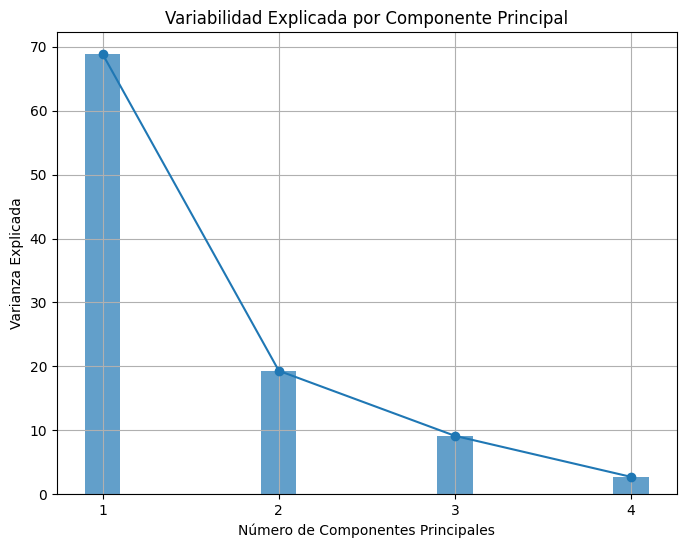

In [21]:
plot_varianza_explicada(explained_var, fit.n_components_)

The graph of Explained Variability by the Principal Component shows the elbow between the second and third components, in the first instance. I have my doubts about whether the third one can be relevant, so I am going to include the 4 as there are a low number of variables to check that I am correct.

In [22]:
pca = PCA(n_components=4)
fit = pca.fit(standard_penguins)

# Obtain the eigenvalues ​​associated with each main component.
eigenvalues = fit.explained_variance_

# Obtain the eigenvectors associated with each principal component and transpose them.
eigenvectors = pd.DataFrame(pca.components_.T, 
                            columns = ['Eigenvector {}'.format(i) for i in range(1, fit.n_components_+1)],
                            index = ['{}_z'.format(variable) for variable in variables])

# We calculate the first two principal components
pca_results = pd.DataFrame(fit.transform(standard_penguins), 
                              columns=['Component {}'.format(i) for i in range(1, fit.n_components_+1)],
                              index=standard_penguins.index)

# We add the main components to the standardized database.
penguins_z_cp = pd.concat([standard_penguins, pca_results], axis=1)


In [23]:
cp_variables = penguins_z_cp.columns

# We save the number of components
n_variables = fit.n_features_in_

# Calculate the covariance matrix between variables and components
cov_var_comp = penguins_z_cp.cov()
cov_var_comp = cov_var_comp.iloc[:fit.n_features_in_, fit.n_features_in_:]

# Calculate the correlation matrix between variables and components
corr_var_comp = penguins_z_cp.corr()
corr_var_comp = corr_var_comp.iloc[:fit.n_features_in_, fit.n_features_in_:]


In [24]:
corr_var_comp

,Component 1,Component 2,Component 3,Component 4
culmen_length_mm_z,0.755463,0.524748,0.389382,-0.047933
culmen_depth_mm_z,-0.664333,0.701180,-0.252875,0.055331
flipper_length_mm_z,0.955862,0.002006,-0.140259,0.258169
body_mass_g_z,0.909957,0.074149,-0.360554,-0.191002


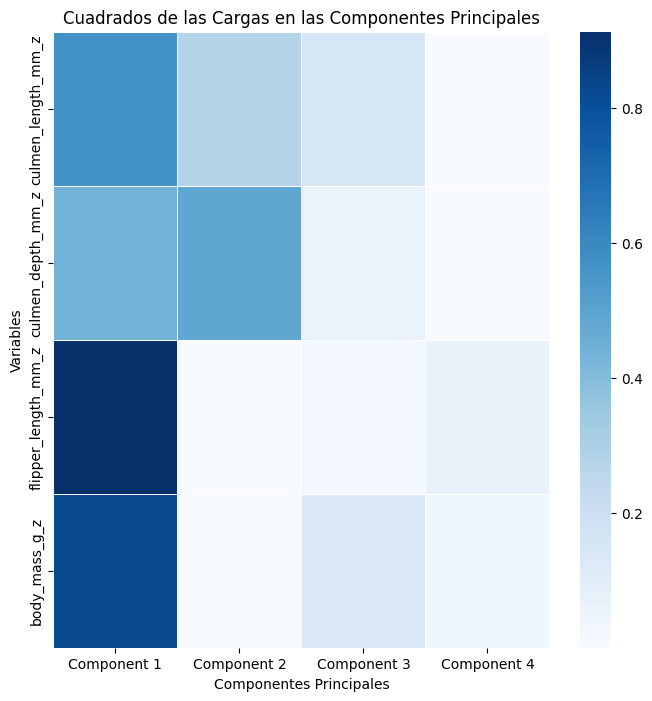

In [25]:
# I proceed to graph the contribution of the components to the Explained Variability of the variables
cos2 = corr_var_comp**2
plot_cos2_heatmap(cos2)

As can be seen, *flipper_length_mm_z* and *body_mass_g_z* are explained practically in their entirety by Component 1, while *bill_depth_mm_z* and *bill_length_mm_z* i> are explained almost entirely by a combination of Component 1 and 2.

# Redoing the principal components analysis on the correlation matrix, this time indicating the number of principal components that we have decided to retain.

In [26]:
# I initialize the PCA variable again, this time with 2 components, and then do fit:
pca = PCA(n_components=2)
fit = pca.fit(standard_penguins)
# I get the eigenvalues associated with each main component.
eigenvalues = fit.explained_variance_
# I get the eigenvectors associated with each principal component and transpose them.
eigenvectors = pd.DataFrame(pca.components_.T, 
                            columns = ['Eigenvector {}'.format(i) for i in range(1, fit.n_components_+1)],
                            index = ['{}_z'.format(variable) for variable in variables])
# I calculate the first two principal components
pca_results = pd.DataFrame(fit.transform(standard_penguins), 
                              columns=['Component {}'.format(i) for i in range(1, fit.n_components_+1)],
                              index=standard_penguins.index)
# I add the main components to the standardized database.
penguins_z_cp = pd.concat([standard_penguins, pca_results], axis=1)

In [27]:
cp_variables = penguins_z_cp.columns
# I save the number of Components
n_variables = fit.n_features_in_
# I calculate the covariance matrix between veriables and Components
cov_var_comp = penguins_z_cp.cov()
cov_var_comp = cov_var_comp.iloc[:fit.n_features_in_, fit.n_features_in_:]
# Calculate the correlation matrix between variables and Components
corr_var_comp = penguins_z_cp.corr()
corr_var_comp = corr_var_comp.iloc[:fit.n_features_in_, fit.n_features_in_:]

In [28]:
corr_var_comp

,Component 1,Component 2
culmen_length_mm_z,0.755463,0.524748
culmen_depth_mm_z,-0.664333,0.701180
flipper_length_mm_z,0.955862,0.002006
body_mass_g_z,0.909957,0.074149


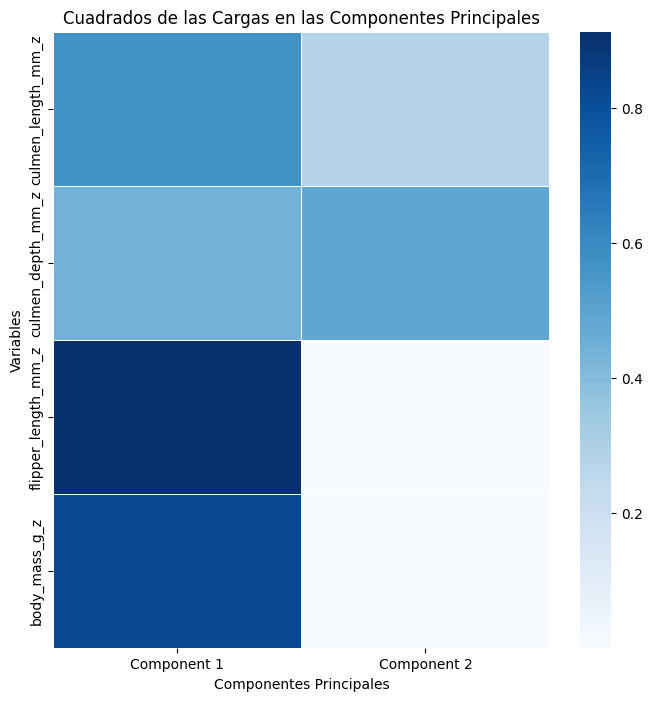

In [29]:
# I proceed to graph the contribution of the Components to the Explained Variability of the variables
cos2 = corr_var_comp**2
plot_cos2_heatmap(cos2)

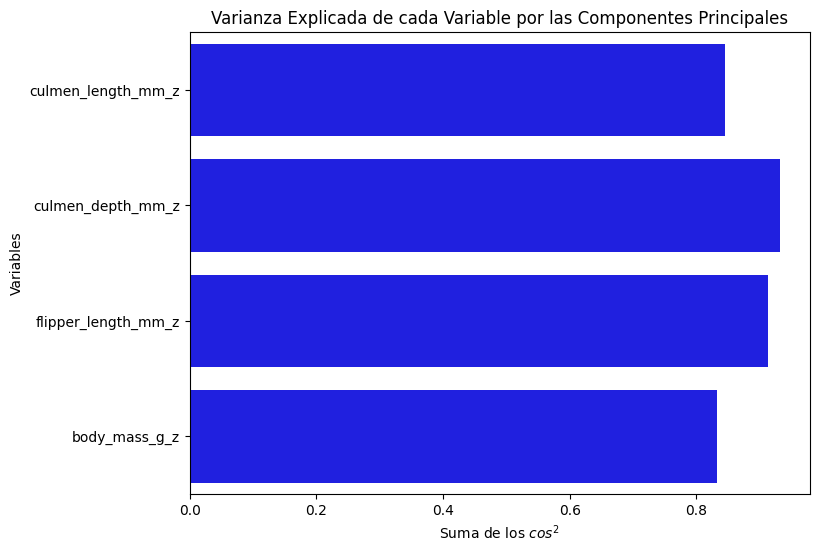

In [30]:
plot_cos2_bars(cos2)

The plot above shows that the two Components can effectively explain the descriptive variables of the penguins. However, the graph of Explained Variance of each Variable by the Principal Components is the most important to know that I am on the right track: all the variables have a sum of squared cosines greater than 0.8, which is a good indication of explainability for the 2 Components defined.

# Explaining what each Component represents in terms of the physical characteristics of the penguins.

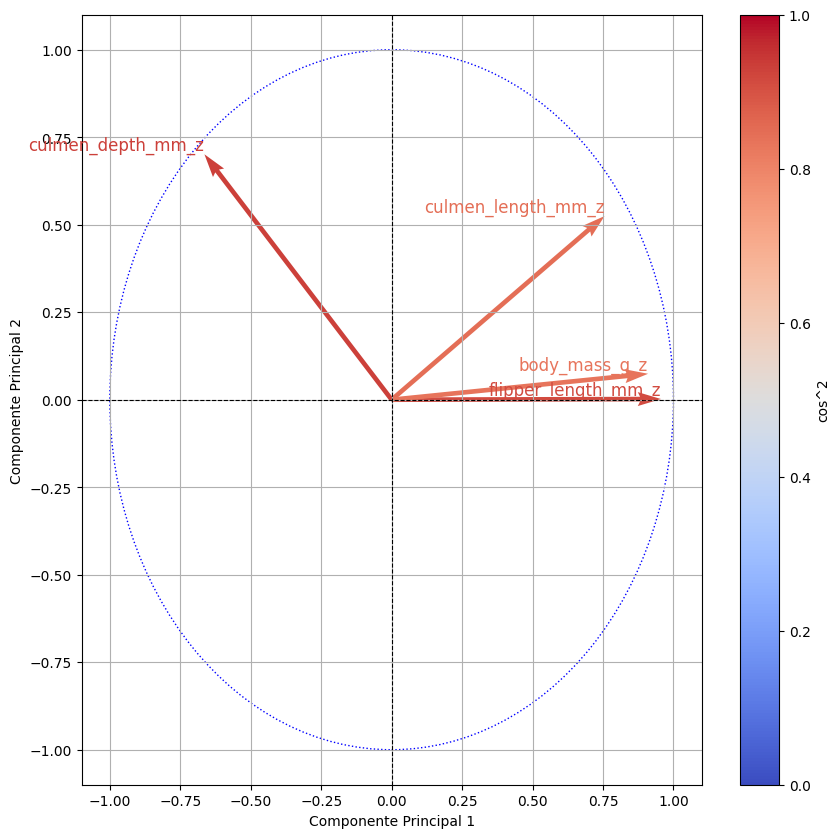

In [31]:
plot_corr_cos(fit.n_components, corr_var_comp)

From the squared cosines correlation graph above, I conclude the following:

- First, a correlation between Principal Component 1 and the corpulence of the penguin species, and likewise a near absence of Principal Component 2 to explain *body_mass_g_z* and *flipper_length_mm_z*. This reinforces the graph of Squares of the Principal Component Loadings, where it can be seen that Component 1 almost completely explains these two variables.
- On the other hand, the cosine graph above shows that *bill_depth_mm_z* and *bill_length_mm_z* are explained by both Component 1 and Component 2. Component 1 is negative for *bill_depth_mm_z*, so it is assumed that penguins with deep beaks they are not the largest. The *bill_length_mm_z* is explained by positive Components 1 and 2.
- None of the variables have a negative Component 2.

# Taking into account the position of the penguin species on the graph, which ones stand out the most in each Component?

In [32]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans.fit(standard_penguins)
kmeans_cluster_labels = kmeans.labels_

In [33]:
pca_k = PCA(n_components=2).fit_transform(standard_penguins)
fit_k = KMeans(n_clusters=2).fit(pca_k)

In [34]:
p_pca = pd.DataFrame(data=pca_k, columns=['PC1', 'PC2'], index=penguins.index)

In [35]:
p_pca

,PC1,PC2
0,-1.843445,0.047702
1,-1.306762,-0.428348
2,-1.369181,-0.154476
4,-1.878827,-0.002048
5,-1.911748,0.829210
...,...,...
338,2.006436,-0.958909
340,1.840886,-0.767714
341,2.760742,0.288886
342,1.722364,-0.704269


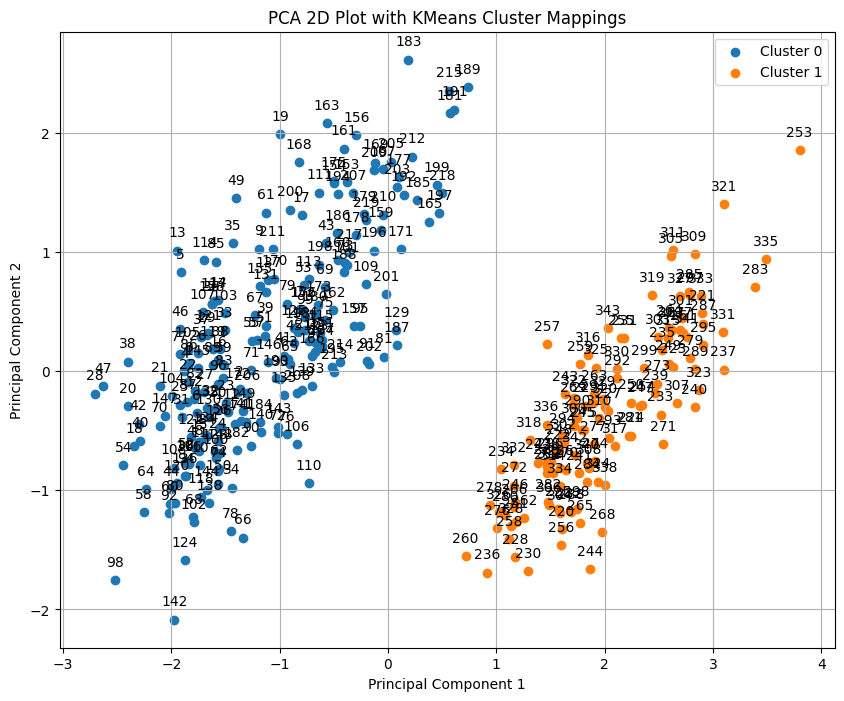

In [36]:
# Create a scatter plot with colors for KMeans clusters
plt.figure(figsize=(10, 8))

# Iterate through unique cluster labels and plot data points with the same color
for cluster in np.unique(kmeans_cluster_labels):
    cluster_indices = p_pca.loc[kmeans_cluster_labels == cluster].index
    plt.scatter(p_pca.loc[cluster_indices, 'PC1'],
                p_pca.loc[cluster_indices, 'PC2'],
                label=f'Cluster {cluster}')  # Poner una etiqueta para cada cluster
    
    # Anotar cada punto con su respectivo indice
    for i in cluster_indices:
        plt.annotate(i,
                     (p_pca.loc[i, 'PC1'], p_pca.loc[i, 'PC2']),fontsize=10,
                     textcoords="offset points",  # Define como se posicionara el texto
                     xytext=(0,10),  # Define la distancia del texto a los puntos (x,y)
                     ha='center')  # Define la alineacion horizontal del texto

# Set the chart title and axis labels
plt.title("PCA 2D Plot with KMeans Cluster Mappings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

In the graph above I identify two clusters clearly formed by Components 1 and 2. The orange clusters have a larger Component 1 and the blue cluster a negative Component 1.

If we plot the correlation of square cosines superimposed on the cluster graph we can better visualize these relationships:

# Relationship between the Principal Components and the Variables, the contributions of the Principal Components to the Explained Variability of the Original Variables and the contributions of the Variables to the Principal Components.

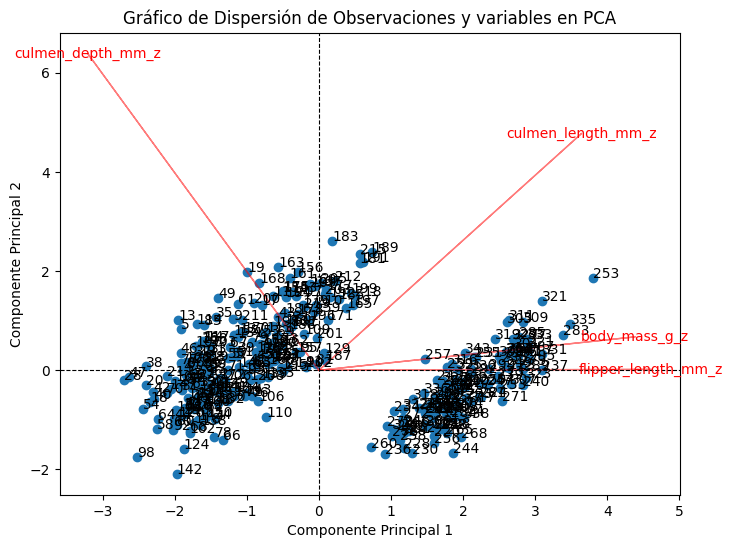

In [37]:
plot_pca_scatter_with_vectors(pca, standard_penguins, fit.n_components, fit.components_)

In the Scatter plot of Observations and variables in PCA, the cluster on the right locates the penguins with the greatest mass and fin length. These are the largest penguins. On the other hand, as Component 2 grows and Component 1 decreases (and therefore, its corpulence), the size and depth of the penguin's beak settle.

Next, I'm interested in how the penguin species differ within this 2D PCA graph with Kmeans:

In [38]:
temp = p_pca.copy()
temp['species'] = save['species']
temp['island'] = save['island']
temp['sex'] = save['sex']

<Axes: xlabel='PC1', ylabel='PC2'>

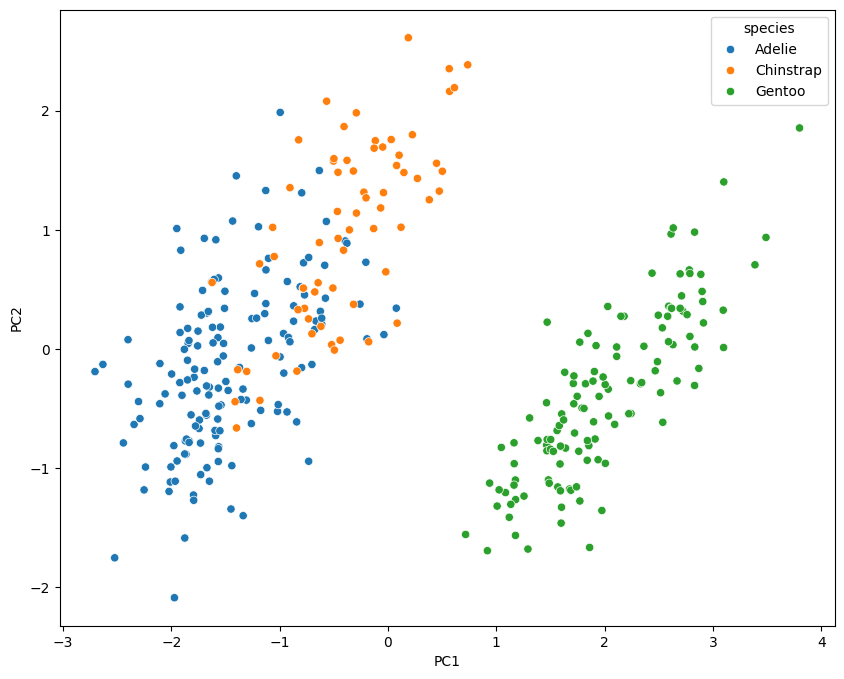

In [39]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=temp, x="PC1", y="PC2",hue="species")

###### This graph is excellent because it suggests that Gentoo is the larger species, while Adelie and Chinstrap trade off size for beak size. Within that cluster, Chinstrap has a larger beak than Adelie.
A comparative image of these penguin species shows that these conclusions are correct:
<div style="text-align: center;">
    <img src="https://i.ibb.co/qWfsrnH/penguins.jpg" width="600"/>
</div>
Gentoo is the largest species. Chinstrap has a bigger beak than Adelie

# Evaluation of Existing Cluster Structures

## Calculate the Distance Matrix
Initially, calculate the matrix
distances between observations, using a distance measure
appropriate, such as the Euclidean distance..

In [40]:
# To calculate the distance matrix, we take the penguin data
distance_matrix = distance.cdist(penguins, penguins, 'euclidean')
distance_df = pd.DataFrame(distance_matrix, index=penguins.index, columns=penguins.index)
# Take the first 5 rows and columns
distance_small = distance_matrix[:5, :5]
distance_small = pd.DataFrame(distance_small, index=penguins.index[:5], columns=penguins.index[:5])
# Round the values ​​to 2
distance_small_rounded = distance_small.round(2)
print("Rounded Distance Matrix:\n", distance_small_rounded)

Rounded Distance Matrix:
         0       1       2       4       5
0    0.00   50.27  500.20  300.25  100.42
1   50.27    0.00  550.07  350.09  150.09
2  500.20  550.07    0.00  200.05  400.04
4  300.25  350.09  200.05    0.00  200.04
5  100.42  150.09  400.04  200.04    0.00


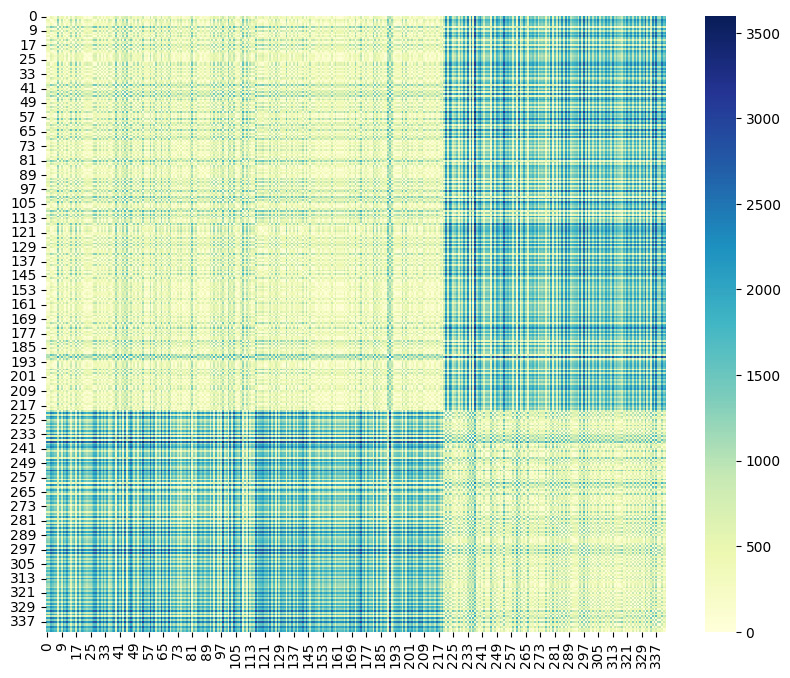

In [41]:
# Graphical representation of the distance matrix:
plt.figure(figsize=(10, 8))
sns.heatmap(distance_df, annot=False, cmap="YlGnBu", fmt=".1f")
plt.show()

The darker colors on the graph show the penguins whose physical characteristics set them further apart from the rest. It's probably the Gentoo. Let's see later!

# Determination of the number of Clusters - Hierarchical Analysis

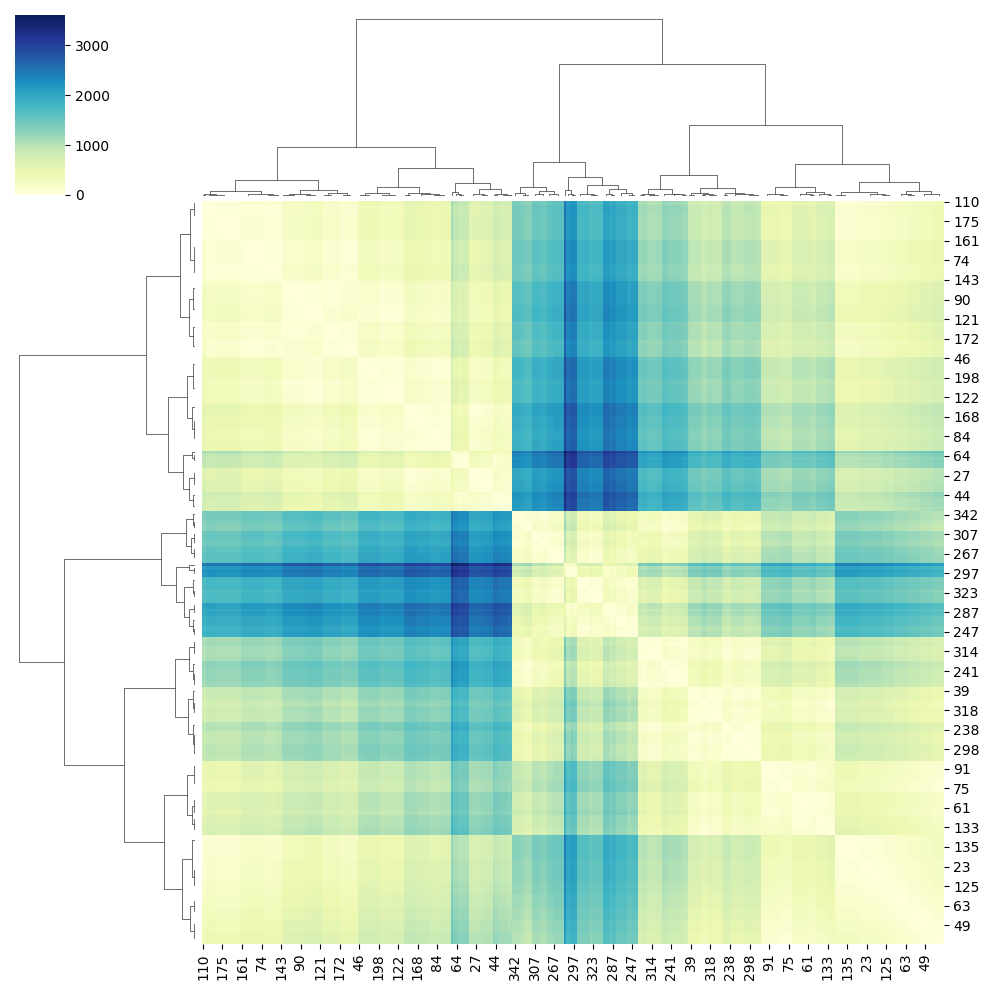

In [42]:
# Next, I use the dendrogram to show the grouping of data:
linkage = sns.clustermap(distance_df, cmap="YlGnBu", fmt=".1f", annot=False, method='ward').dendrogram_row

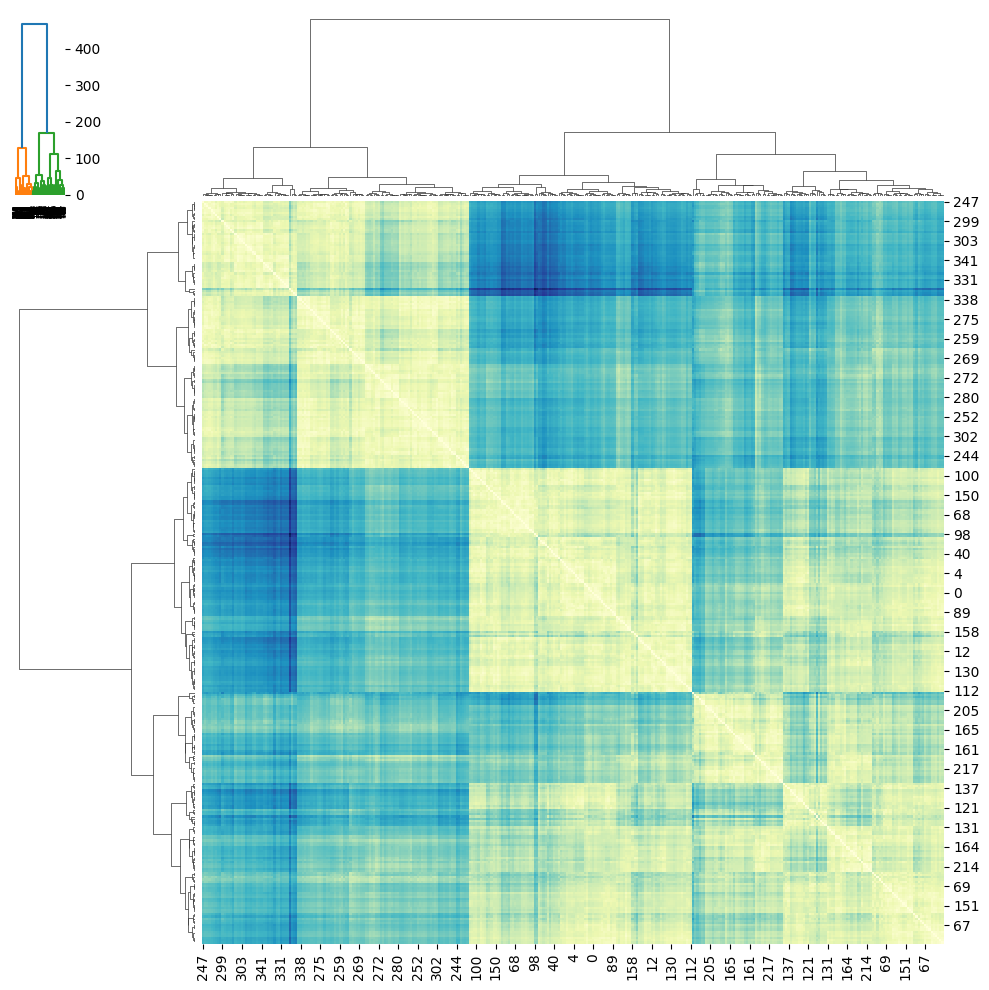

In [43]:
# First I prepare the standardized dataframe of the penguins
scaler = StandardScaler()
df_std = pd.DataFrame(scaler.fit_transform(penguins), columns=penguins.columns)
df_std.index = penguins.index
# Get the Euclidean distance
distance_std = distance.cdist(df_std, df_std, 'euclidean') 
df_std_distance = pd.DataFrame(distance_std, index=df_std.index, columns=df_std.index)
linkage = sns.clustermap(df_std_distance, cmap="YlGnBu", fmt=".1f", annot=False, method='ward').dendrogram_row
linkage_matrix = sch.linkage(df_std_distance, method='ward')
dendrogram = sch.dendrogram(linkage_matrix, labels=df_std_distance.index.tolist(), leaf_rotation=90)
plt.show()

The graph above shows the correlation matrix of the penguins standardized and represented in a heatmap in conjunction with a dendrogram.

Next, I am going to show the dendrogram to better visualize the clusters that can form:

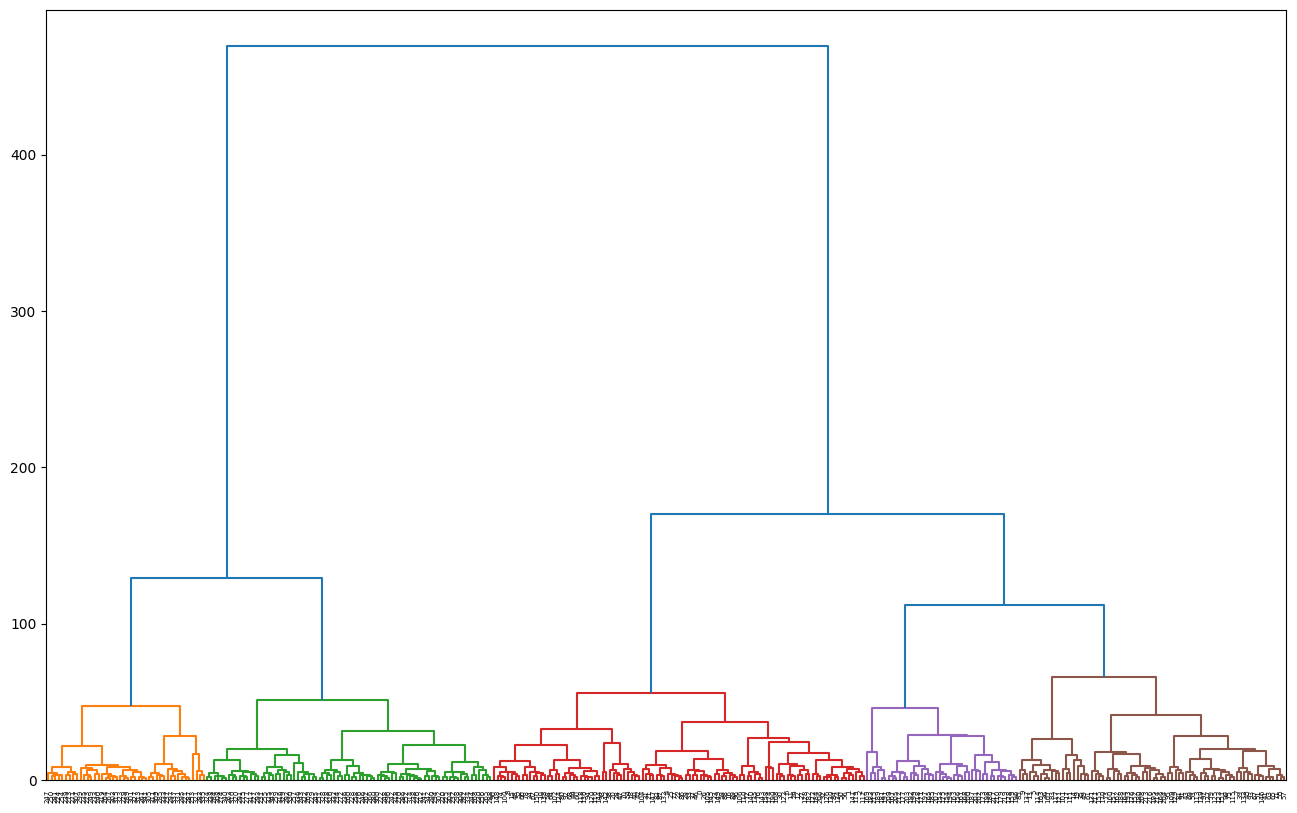

In [44]:
plt.figure(figsize=(16, 10))
color_threshold =100
# Create the dendrogram with the specified color threshold
dendrogram = sch.dendrogram(linkage_matrix, labels=df_std_distance.index.tolist(), leaf_rotation=90, color_threshold=color_threshold)
plt.show()

Using a threshold of 100 I obtain 4 groups. I am going to proceed to plot 4 clusters using a function that is found in *py* and performs the entire PCA process:

Gráfico para 4 clusters
              Autovalores  Variabilidad Explicada  Variabilidad Acumulada
Componente 1     2.761831               68.843878               68.843878
Componente 2     0.774782               19.312919               88.156797


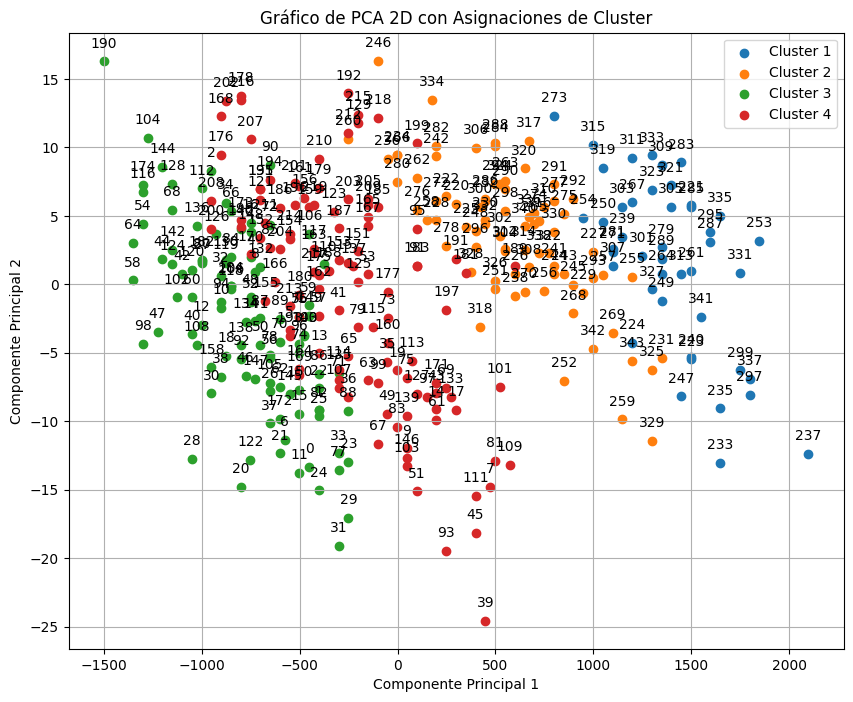

In [45]:
num_clusters = 4
GraficarClusters(num_clusters,linkage_matrix,penguins,df_std)

Honestly, I am not convinced by this number of clusters because many observations are mixed between the groups. Let's try to find a higher threshold:

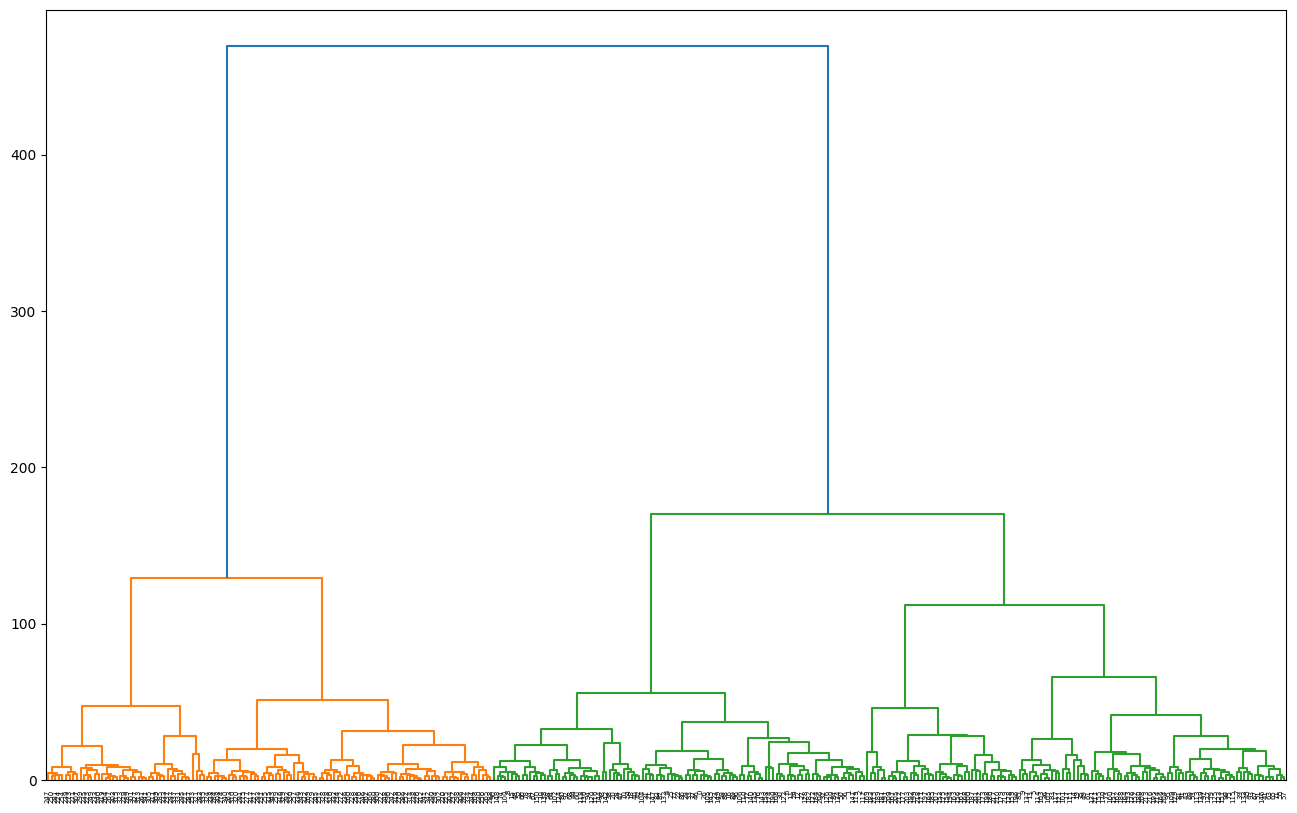

In [46]:
plt.figure(figsize=(16, 10))
color_threshold =200
dendrogram = sch.dendrogram(linkage_matrix, labels=df_std_distance.index.tolist(), leaf_rotation=90, color_threshold=color_threshold)
plt.show()

Let's try two clusters:Probemos con dos clusters:

Gráfico para 2 clusters
              Autovalores  Variabilidad Explicada  Variabilidad Acumulada
Componente 1     2.761831               68.843878               68.843878
Componente 2     0.774782               19.312919               88.156797


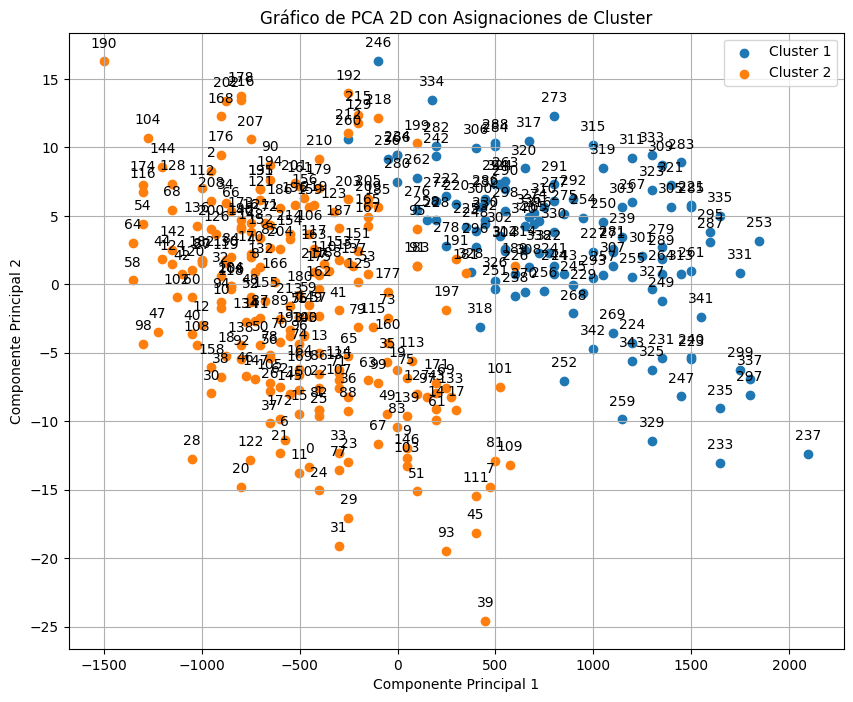

In [47]:
num_clusters = 2
GraficarClusters(num_clusters,linkage_matrix,penguins,df_std)

This 2-cluster graph looks better than the 4-cluster one.

Finally, I am going to run the same code with the 3 clusters that we identified in the first part of the task. That is, one cluster for each species:

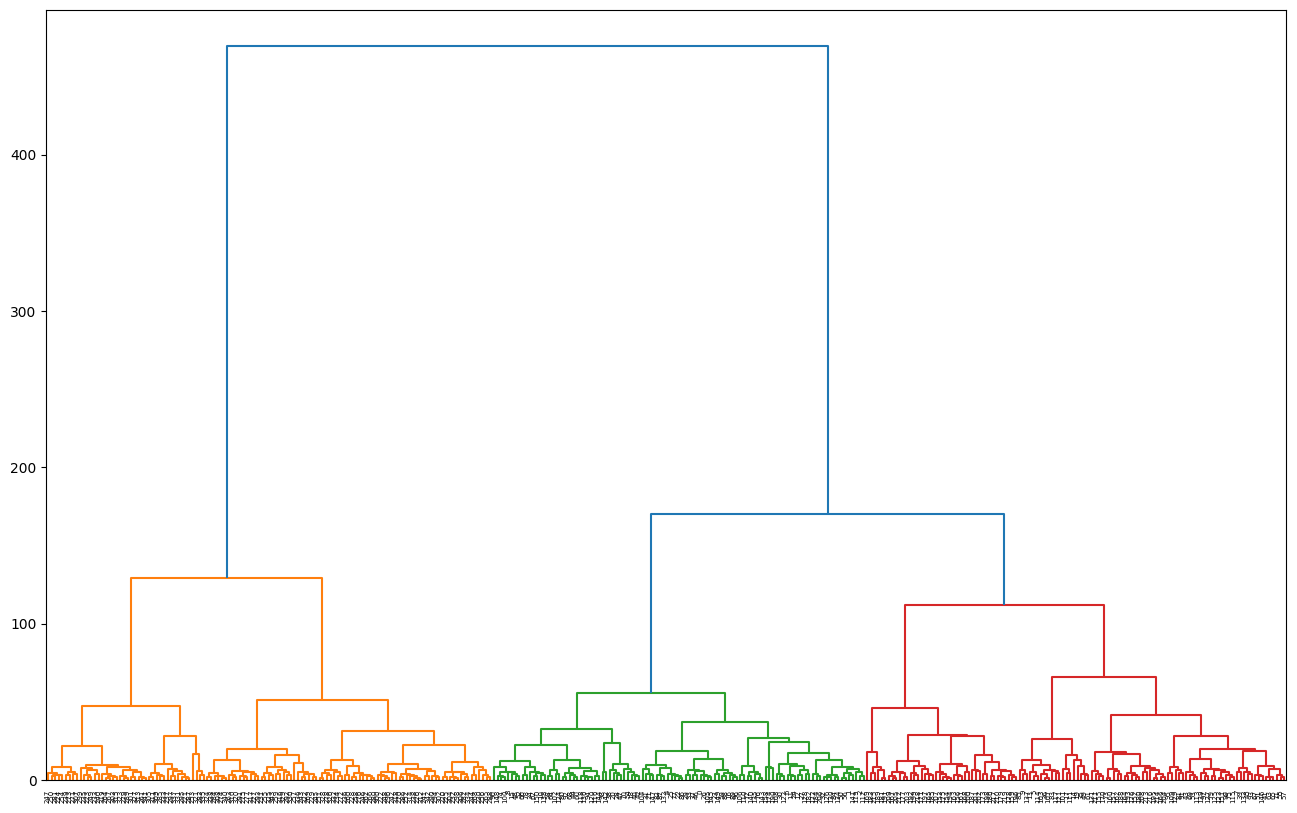

In [48]:
plt.figure(figsize=(16, 10))
color_threshold =150
dendrogram = sch.dendrogram(linkage_matrix, labels=df_std_distance.index.tolist(), leaf_rotation=90, color_threshold=color_threshold)
plt.show()

Gráfico para 3 clusters
              Autovalores  Variabilidad Explicada  Variabilidad Acumulada
Componente 1     2.761831               68.843878               68.843878
Componente 2     0.774782               19.312919               88.156797


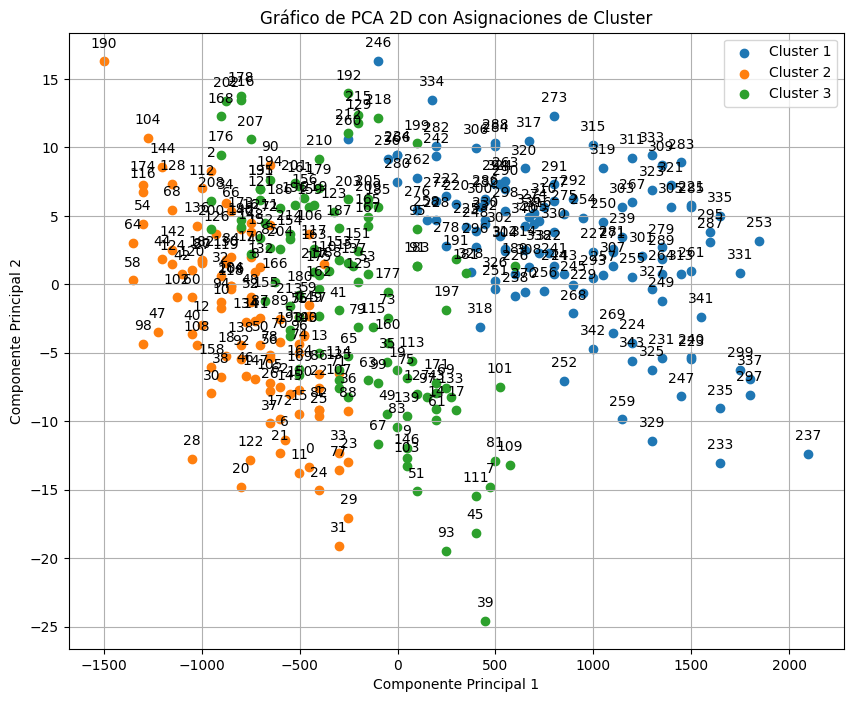

In [49]:
num_clusters = 3
GraficarClusters(num_clusters,linkage_matrix,penguins,df_std)

It looks very similar to the graph I got in the first part. However, these groups are closer to each other.

Hierarchical Cluster Analysis suggests that the appropriate number of clusters is 2. I believe that with non-hierarchical analysis I will obtain the final number of clusters.

# Non-Hierarchical Cluster Analysis
Once the number of clusters has been decided, perform a non-hierarchical cluster analysis (K-means) using the number of clusters identified in the previous step.

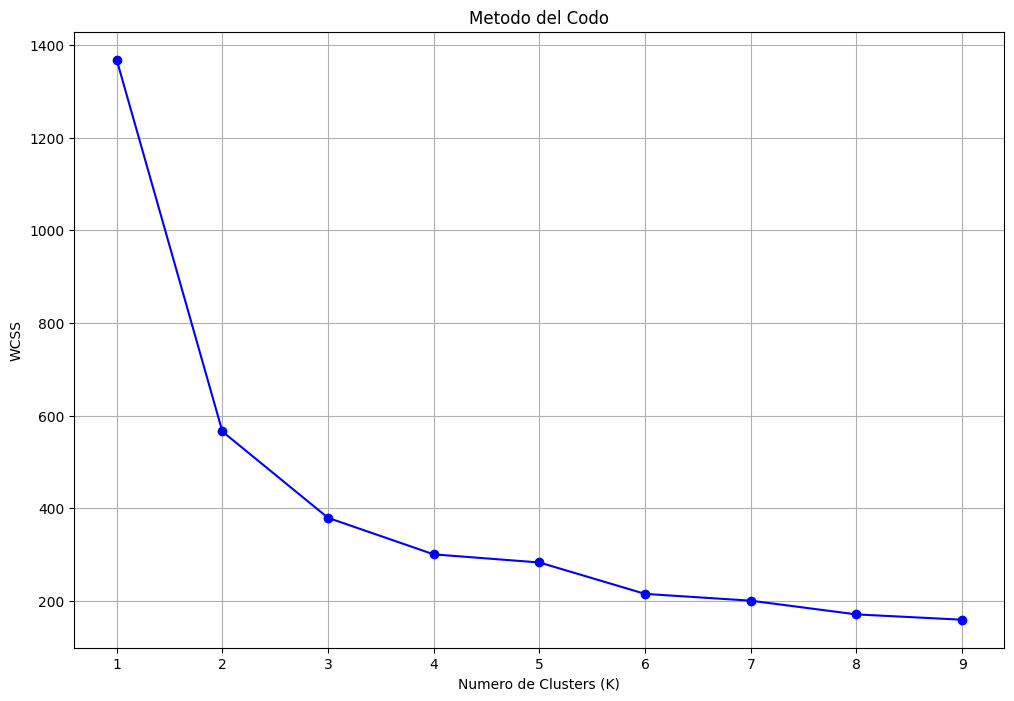

In [50]:
wcss = []  
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_std)
    wcss.append(kmeans.inertia_)
# Plot the WCSS values against the number of groups (K) and we look for the "elbow" point
plt.figure(figsize=(12, 8))
plt.plot(range(1, 10), wcss, marker='o', linestyle='-', color='b')
plt.title('Metodo del Codo')
plt.xlabel('Numero de Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

From the previous Graph showing the Elbow Method, an important inflection is observed between 2 and 3 clusters. Just as in the previous analysis, there is a case for supporting both numbers of clusters. However, it seems to me that the inflection occurs in 2.

# Evaluation of the Quality of Groups

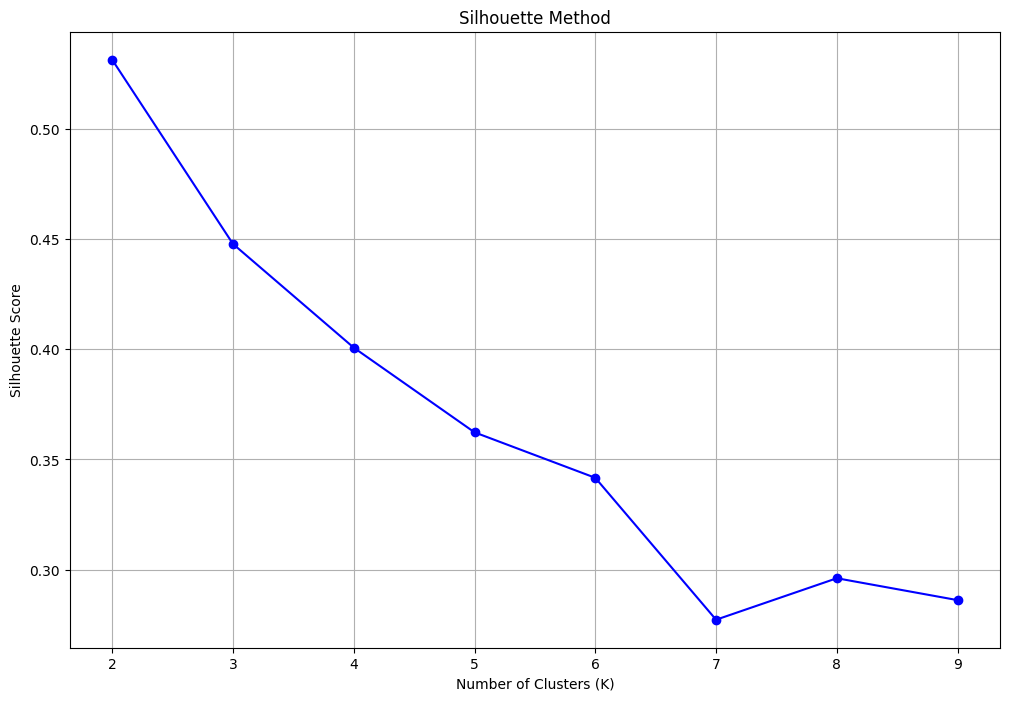

In [51]:
silhouette_scores = []
# Run K-means clustering for a range of K values ​​and calculate the silhouette score for each K
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_std)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_std, labels)
    silhouette_scores.append(silhouette_avg)
    
# Plot the silhouette scores against the number of clusters (K)
plt.figure(figsize=(12, 8))
plt.plot(range(2, 10), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

This graph with the silhouette method does not contribute substantially, since it does not show any inflection that generates a maximum during the descent.

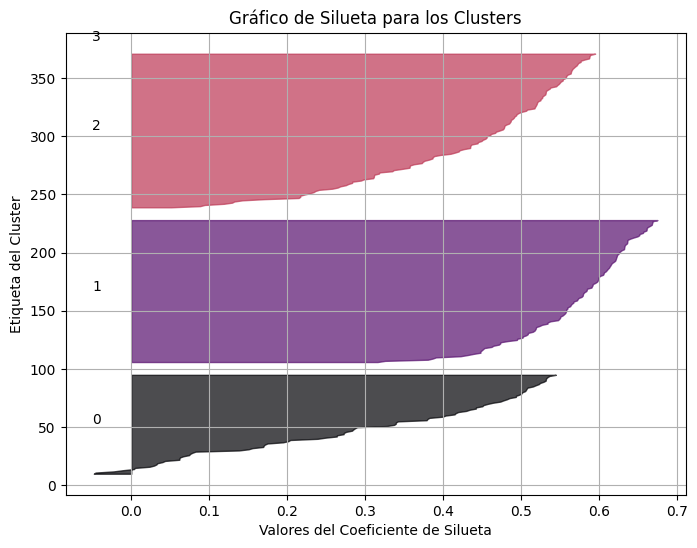

In [52]:
# Gráficos de Silueta para Clusters definidos
clusters = 3
SilhouetteGraph(clusters,df_std)

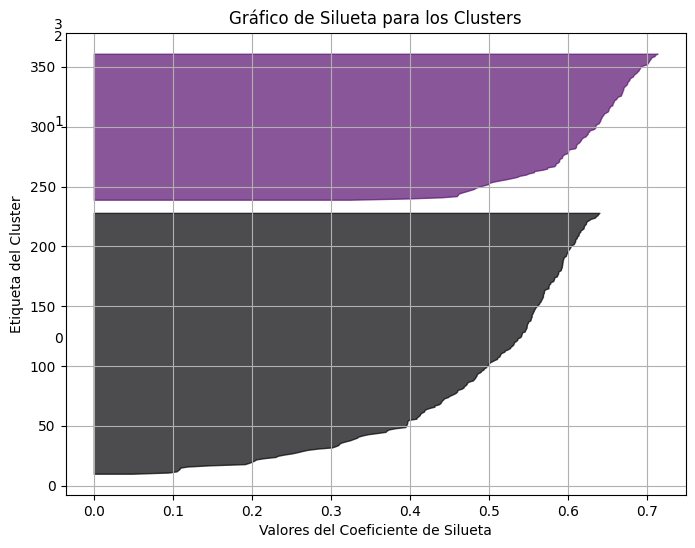

In [53]:
# Silhouette Plots for Defined Clusters
clusters = 2
SilhouetteGraph(clusters,df_std)

The graph corresponding to 3 clusters shows that the third silhouette has a part of it with values ​​less than zero, which indicates that some of the observations have been assigned to an incorrect cluster.
On the other hand, the graph with 2 clusters shows that it is the correct number that defines the penguin groupings, since none of the silhouettes have values ​​less than zero.

Therefore, with the silhouette method we conclude that <b>the appropriate number of clusters is two.</b>

## Characterization of the Clusters

In [54]:
# Configure the KMeans model with n clusters and a fixed random state
kmeans2 = KMeans(n_clusters=2, random_state=0)
# Fit the KMeans model to the standardized data
kmeans2.fit(df_std)
labels = kmeans2.labels_
# Start with the means
penguins['Cluster'] = labels
penguins.drop(columns=['Cluster4'],inplace=True)

In [55]:
# Sort the DataFrame by the "Cluster" column
df_sort = penguins.sort_values(by="Cluster")
pengC0 = df_sort.loc[df_sort['Cluster']==0]
pengC0.set_index('Cluster',inplace=True)
pengC1 = df_sort.loc[df_sort['Cluster']==1]
pengC1.set_index('Cluster',inplace=True)

In [56]:
cluster_centroids_orig = df_sort.groupby('Cluster').mean()
# Round the values for easy viewing
cluster_centroids_orig.round(2)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
Cluster,,,,
0,41.91,18.37,191.78,3710.73
1,47.50,14.98,217.19,5076.02


With the previous table showing the means of the values ​​of each Cluster, we can observe, on the one hand, that Cluster 1 has larger penguins than Cluster 0 in all variables except beak depth. However, the difference that exists in the mean of this variable is small.

I am going to continue to obtain more relevant statistics to reach a more accurate conclusion:

# Final Conclusions

In [57]:
GetStats(pengC0,pengC1)

,Mínimo,Percentil 25,Mediana,Percentil 75,Media,Máximo,Desviación Estándar,Varianza,Datos Perdidos
body_mass_g___0,2700.0,3400.00,3700.0,3987.50,3710.73,4800.0,436.25,190314.37,0
body_mass_g___1,3950.0,4700.00,5000.0,5500.00,5076.02,6300.0,504.12,254133.18,0
culmen_depth_mm___0,15.5,17.50,18.4,19.10,18.37,21.5,1.19,1.42,0
culmen_depth_mm___1,13.1,14.20,15.0,15.70,14.98,17.3,0.98,0.96,0
culmen_length_mm___0,32.1,37.75,40.6,45.95,41.91,58.0,5.48,30.00,0
culmen_length_mm___1,40.9,45.30,47.3,49.55,47.50,59.6,3.08,9.50,0
flipper_length_mm___0,172.0,187.00,191.0,196.00,191.78,212.0,7.24,52.47,0
flipper_length_mm___1,203.0,212.00,216.0,221.00,217.19,231.0,6.48,42.05,0


Below are my observations on the previous table:
- The first 4 rows have to do with the characteristics of the penguin's beak. A difference, although small, can be seen between Cluster 0 and 1, with Cluster 0 having the most pronounced peak depth characteristics.
- The same happens with the length of the peak, with Cluster 1 generally having longer peaks and a lower standard deviation.
- The last 4 rows have to do with the corpulence of the penguins. In these cases, a much more marked difference is seen between Cluster 1 and 0. That is, Cluster 1 shows penguins with greater corpulence and larger fins. In fact, all of the descriptive statistics in the last 4 rows are greater in Cluster 1 than in 0.

Therefore, I can conclude the following:
- Cluster 1 belongs to the Gentoo species penguins, which are larger.
- Cluster 0 encompasses the other two species described in the dataset: Adelie and Chinstrap.
- Although there are 3 species of penguins, the mass and fin length of the penguins (corpulence) have turned out to be the most relevant variables that explain and separate the Clusters, above the variable that details the species.
- In other words, while Adelie and Chinstrap are distinct by their beaks, the best way to separate the penguin dataset is by their stoutness. This is due to the number of observations that are shared within Cluster 0 between Adélie and Chistrap penguins.

Finally, let's review how categorical variables help explain this division of Clusters:

<Axes: xlabel='PC1', ylabel='PC2'>

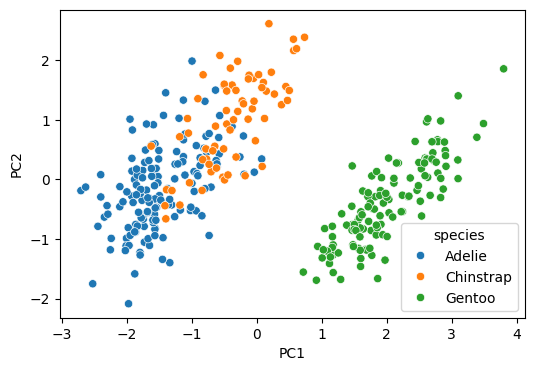

In [58]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=temp, x="PC1", y="PC2",hue="species")

Recalling the graph of observations with colors describing the penguin species, you can see that the conclusions I have written agree with the data: there are two clear clusters that separate Gentoo from Adelie and Chinstrap. The observations of these last two are mixed and, therefore, it is not possible to separate them into Clusters.

<Axes: xlabel='PC1', ylabel='PC2'>

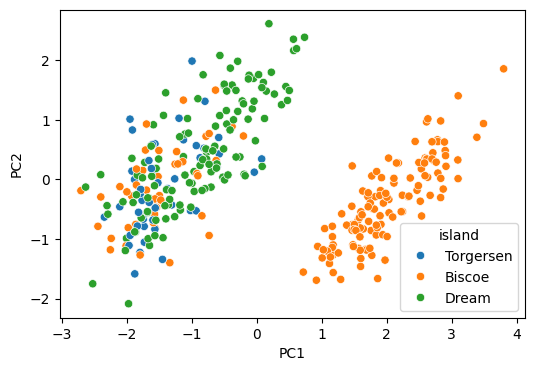

In [59]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=temp, x="PC1", y="PC2",hue="island")

The graph of penguin observations by island does not show a clear relationship between the clusters and the island where they live. The only thing that can be inferred from the data is that Biscoe Island is inhabited by Gentoo, and the rest of the species (including some Gentoo) inhabit the other Torgesen and Dream islands. However, there is no direct relationship between Components and the island where they live.

<Axes: xlabel='PC1', ylabel='PC2'>

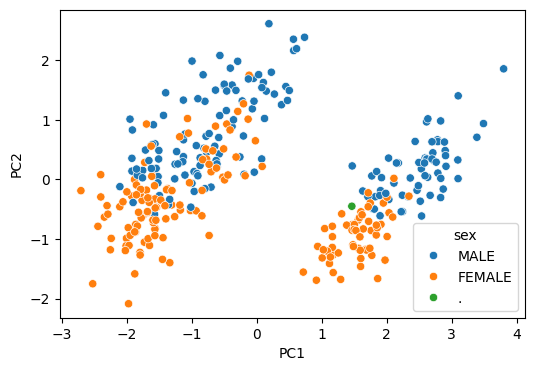

In [60]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=temp, x="PC1", y="PC2",hue="sex")

When reviewing the observations for both the island and sex variables, it is seen that in both cases there are mixed observations between the Clusters. Perhaps the only thing notable about the last graph that separates the penguins by sex is that in general, the females have a slightly smaller corpulence as their Component 1 is located more to the left, and the beak is less deep and long than in the males. .

Finally, we can conclude that the data show a separation determined by the corpulence of the penguins to identify the Adelie and Chinstrap Gentoos.